In [41]:
import pathlib
import shlex
import subprocess
from string import Template

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
import tqdm.notebook as tqdm

In [2]:
n_features = 10
n_projections = 10

# SAIGE

# Features

In [3]:
command_template = Template("""
docker run \
    -v ./data:/data -w / \
    wzhou88/saige:1.3.0 step1_fitNULLGLMM.R \
    --plinkFile=data/simulated-phenotypes/Genotypes \
    --useSparseGRMtoFitNULL=FALSE \
    --covarColList=sharedConfounder_norm1,sharedConfounder_norm2,sharedConfounder_norm3,independentConfounder_norm1,independentConfounder_norm2 \
    --sampleIDColinphenoFile=IID \
    --invNormalize=FALSE \
    --traitType=quantitative \
    --nThreads=16 \
    --IsOverwriteVarianceRatioFile=TRUE \
    --phenoCol=$PHENOTYPE \
    --phenoFile=data/simulated-phenotypes/Ysim_saige.txt \
    --outputPrefix=data/gwas/saige/features-unnormed/$PHENOTYPE
""")

for feature_idx in tqdm.tnrange(1, n_features + 1):
    command = command_template.substitute(PHENOTYPE=f"feature_{feature_idx:02}")
    result = subprocess.run(shlex.split(command), capture_output=True)
    result.check_returncode()

  0%|          | 0/10 [00:00<?, ?it/s]

In [4]:
command_template = Template("""
docker run \
    -v ./data:/data -w / \
    wzhou88/saige:1.3.0 step2_SPAtests.R \
    --bedFile=data/simulated-phenotypes/Genotypes.bed \
    --bimFile=data/simulated-phenotypes/Genotypes.bim \
    --famFile=data/simulated-phenotypes/Genotypes.fam \
    --LOCO=FALSE \
    --GMMATmodelFile=data/gwas/saige/features-unnormed/$PHENOTYPE.rda \
    --varianceRatioFile=data/gwas/saige/features-unnormed/$PHENOTYPE.varianceRatio.txt \
    --SAIGEOutputFile=data/gwas/saige/features-unnormed/$PHENOTYPE.txt
""")

for feature_idx in tqdm.tnrange(1, n_features + 1):
    command = command_template.substitute(PHENOTYPE=f"feature_{feature_idx:02}")
    result = subprocess.run(shlex.split(command), capture_output=True)
    try:
        result.check_returncode()
    except Exception as e:
        print(result.stderr.decode())

  0%|          | 0/10 [00:00<?, ?it/s]

## Projections

In [6]:
command_template = Template("""
docker run \
    -v ./data:/data -w / \
    wzhou88/saige:1.3.0 step1_fitNULLGLMM.R \
    --plinkFile=data/simulated-phenotypes/Genotypes \
    --useSparseGRMtoFitNULL=FALSE \
    --covarColList=sharedConfounder_norm1,sharedConfounder_norm2,sharedConfounder_norm3,independentConfounder_norm1,independentConfounder_norm2 \
    --sampleIDColinphenoFile=IID \
    --invNormalize=TRUE \
    --traitType=quantitative \
    --nThreads=16 \
    --IsOverwriteVarianceRatioFile=TRUE \
    --phenoCol=$PHENOTYPE \
    --phenoFile=data/projected-phenotypes/phenotypes_saige.tsv \
    --outputPrefix=data/gwas/saige/projections-unnormed/$PHENOTYPE
""")

for projection_idx in tqdm.tnrange(1, n_projections + 1):
    command = command_template.substitute(PHENOTYPE=f"projection_{projection_idx:03}")
    result = subprocess.run(shlex.split(command), capture_output=True)
    try:
        result.check_returncode()
    except Exception as e:
        print(result.stderr.decode())

  0%|          | 0/10 [00:00<?, ?it/s]

Loading required package: optparse
Error in glmmkin.ai_PCG_Rcpp_Quantitative(bedFile, bimFile, famFile, Xorig,  : 
  ERROR! The first variance component parameter estimate is 0
Calls: fitNULLGLMM -> system.time -> glmmkin.ai_PCG_Rcpp_Quantitative
Timing stopped at: 13.91 0.139 1.974
Execution halted



In [7]:
command_template = Template("""
docker run \
    -v ./data:/data -w / \
    wzhou88/saige:1.3.0 step2_SPAtests.R \
    --bedFile=data/simulated-phenotypes/Genotypes.bed \
    --bimFile=data/simulated-phenotypes/Genotypes.bim \
    --famFile=data/simulated-phenotypes/Genotypes.fam \
    --LOCO=FALSE \
    --GMMATmodelFile=data/gwas/saige/projections-unnormed/$PHENOTYPE.rda \
    --varianceRatioFile=data/gwas/saige/projections-unnormed/$PHENOTYPE.varianceRatio.txt \
    --SAIGEOutputFile=data/gwas/saige/projections-unnormed/$PHENOTYPE.txt
""")

for projection_idx in tqdm.tnrange(1, n_projections + 1):
    command = command_template.substitute(PHENOTYPE=f"projection_{projection_idx:03}")
    result = subprocess.run(shlex.split(command), capture_output=True)
    try:
        result.check_returncode()
    except Exception as e:
        print(result.stderr.decode())

  0%|          | 0/10 [00:00<?, ?it/s]

Loading required package: RhpcBLASctl
Error in load(GMMATmodelFile) : empty (zero-byte) input file
Calls: SPAGMMATtest -> ReadModel -> load
Execution halted



# Indirect GWAS

In [37]:
direct_gwas_df = (
    pl.scan_csv("data/gwas/saige/projections-unnormed/projection_[01][0123456789][0123456789].txt", separator="\t", glob=True, include_file_paths="projection")
    .select(
        pl.col("projection")
            .str.strip_prefix("data/gwas/saige/projections-unnormed/")
            .str.strip_suffix(".txt"),
        pl.col("MarkerID").alias("snp_id"),
        pl.col("BETA", "SE").name.map(lambda x: x.lower())
    )
    .collect()
)
direct_gwas_df.head(2)

projection,snp_id,beta,se
str,str,f64,f64
"""projection_001""","""SNP_1""",0.001239,0.0120804
"""projection_001""","""SNP_10""",0.008536,0.0120384


In [9]:
projection_df = (
    pl.read_csv("data/projected-phenotypes/projection_matrix.tsv", separator="\t")
    .to_pandas()
    .set_index("index")
)
projection_df.head(2)

,projection_001,projection_002,projection_003,projection_004,projection_005,projection_006,projection_007,projection_008,projection_009,projection_010
index,,,,,,,,,,
feature_01,0.494257,0.149846,0.416713,0.465716,0.499354,-0.403010,0.566804,-0.059001,-0.035533,0.165651
feature_02,0.040359,0.544579,0.324024,0.025287,0.118682,0.137601,0.891338,-0.079973,0.107773,-0.344575


In [10]:
feature_gwas_df = (
    pl.scan_csv("data/gwas/saige/features-unnormed/feature_[01][0123456789].txt", separator="\t", glob=True, include_file_paths="feature")
    .select(
        pl.col("feature")
            .str.strip_prefix("data/gwas/saige/features/")
            .str.strip_suffix(".txt"),
        pl.col("MarkerID").alias("snp_id"),
        pl.col("BETA", "SE").name.map(lambda x: x.lower())
    )
    .collect()
)
feature_gwas_df.head(2)

feature,snp_id,beta,se
str,str,f64,f64
"""data/gwas/saige/features-unnor…","""SNP_1""",-0.020836,0.0108679
"""data/gwas/saige/features-unnor…","""SNP_10""",-0.005789,0.01083


In [29]:
beta_df = (
    feature_gwas_df
    .with_columns(
        pl.col("feature").str.strip_prefix("data/gwas/saige/features-unnormed/")
    )
    .pivot(index="feature", on="snp_id", values="beta")
    .to_pandas()
    .set_index("feature")
    .T
)

In [44]:
comparison_df = (
    (beta_df @ projection_df)
    .melt(ignore_index=False, var_name="projection", value_name="beta")
    .reset_index()
    .pipe(pl.DataFrame)
    .rename({"index": "snp_id"})
    .join(direct_gwas_df, on=["snp_id", "projection"], suffix="_indirect")
)

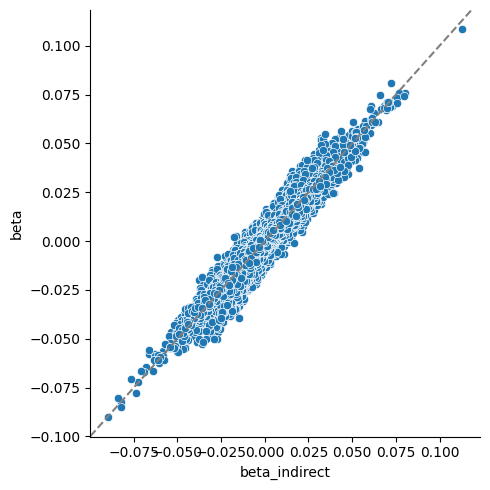

In [45]:
(
    comparison_df
    .pipe(sns.relplot, x="beta_indirect", y="beta", kind="scatter", facet_kws={"sharex": False, "sharey": False})
    .map(lambda *args, **kwargs: plt.axline((0.01, 0.01), slope=1, color="gray", linestyle="dashed"))
)

In [46]:
(
    comparison_df
)

snp_id,projection,beta,beta_indirect,se
str,str,f64,f64,f64
"""SNP_1""","""projection_001""",-0.001358,0.001239,0.0120804
"""SNP_10""","""projection_001""",0.006864,0.008536,0.0120384
"""SNP_100""","""projection_001""",-0.016337,-0.013542,0.0120667
"""SNP_1000""","""projection_001""",0.012045,0.0134747,0.0146847
"""SNP_10000""","""projection_001""",-0.071983,-0.072548,0.0197583
…,…,…,…,…
"""SNP_9995""","""projection_010""",-0.011308,-0.009302,0.0121883
"""SNP_9996""","""projection_010""",-0.022216,-0.020412,0.0121869
"""SNP_9997""","""projection_010""",-0.004144,-0.003466,0.0197498
